## Generate mesh with `gmsh`

In [1]:
import gmsh
import numpy as np

dim = 3
lc = 2

gmsh.initialize()

In [2]:
lx = 1000
ly = 100
lz = 30

In [3]:
from math import atan2, pi, tan

In [4]:
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", lc)
gmsh.option.setNumber("Mesh.CharacteristicLengthMin", lc)

track = gmsh.model.occ.addBox(0., 0., 0., lx, ly, lz)

def wedge(base_mid_x, height, angle):
    base_half_length = height * np.tan(angle/2.0)
    base_lb = gmsh.model.occ.addPoint(base_mid_x - base_half_length, ly, 0)
    base_rb = gmsh.model.occ.addPoint(base_mid_x + base_half_length, ly, 0)
    hb = gmsh.model.occ.addPoint(base_mid_x, ly - height, 0)
    base_lt = gmsh.model.occ.addPoint(base_mid_x - base_half_length, ly, lz)
    base_rt = gmsh.model.occ.addPoint(base_mid_x + base_half_length, ly, lz)
    ht = gmsh.model.occ.addPoint(base_mid_x, ly - height, lz)
    
    line_l_b_surf = gmsh.model.occ.addLine(hb, base_lb)
    line_b_b_surf = gmsh.model.occ.addLine(base_lb, base_rb)
    line_r_b_surf = gmsh.model.occ.addLine(base_rb, hb)
    line_l_t_surf = gmsh.model.occ.addLine(ht, base_lt)
    line_b_t_surf = gmsh.model.occ.addLine(base_lt, base_rt)
    line_r_t_surf = gmsh.model.occ.addLine(base_rt, ht)
    line_h_vert = gmsh.model.occ.addLine(hb, ht)
    line_l_vert = gmsh.model.occ.addLine(base_lb, base_lt)
    line_r_vert = gmsh.model.occ.addLine(base_rb, base_rt)
    
    b_loop = gmsh.model.occ.addCurveLoop([line_l_b_surf, line_b_b_surf, line_r_b_surf])
    t_loop = gmsh.model.occ.addCurveLoop([line_l_t_surf, line_b_t_surf, line_r_t_surf])
    lat_l_loop = gmsh.model.occ.addCurveLoop([line_l_t_surf, line_h_vert, line_l_b_surf, line_l_vert])
    lat_r_loop = gmsh.model.occ.addCurveLoop([line_r_t_surf, line_h_vert, line_r_b_surf, line_r_vert])
    lat_base_loop = gmsh.model.occ.addCurveLoop([line_b_b_surf, line_r_vert, line_b_t_surf, line_l_vert])
    
    b_surf = gmsh.model.occ.addSurfaceFilling(b_loop)
    t_surf = gmsh.model.occ.addSurfaceFilling(t_loop)
    lat_l_surf = gmsh.model.occ.addSurfaceFilling(lat_l_loop)
    lat_r_surf = gmsh.model.occ.addSurfaceFilling(lat_r_loop)
    lat_base_surf = gmsh.model.occ.addSurfaceFilling(lat_base_loop)
    
    surf_loop = gmsh.model.occ.addSurfaceLoop([b_surf, t_surf, lat_l_surf, lat_r_surf, lat_base_surf])
    return gmsh.model.occ.addVolume([surf_loop])

In [5]:
for x in [200, 400, 600, 800]:
    wedge_cut = wedge(x, 30, pi/2)
    gmsh.model.occ.cut([(dim, track)], [(dim, wedge_cut)])

In [6]:
gmsh.model.occ.synchronize()

gmsh.model.add_physical_group(dim=dim, tags=[track])

gmsh.model.mesh.generate(dim)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 20%] Meshing curve 6 (Line)
Info    : [ 20%] Meshing curve 7 (Line)
Info    : [ 20%] Meshing curve 8 (Line)
Info    : [ 20%] Meshing curve 9 (Line)
Info    : [ 20%] Meshing curve 10 (Line)
Info    : [ 30%] Meshing curve 11 (Line)
Info    : [ 30%] Meshing curve 12 (Line)
Info    : [ 30%] Meshing curve 13 (Line)
Info    : [ 30%] Meshing curve 14 (Line)
Info    : [ 30%] Meshing curve 15 (Line)
Info    : [ 40%] Meshing curve 16 (Line)
Info    : [ 40%] Meshing curve 17 (Line)
Info    : [ 40%] Meshing curve 18 (Line)
Info    : [ 40%] Meshing curve 19 (Line)
Info    : [ 40%] Meshing curve 20 (Line)
Info    : [ 50%] Meshing curve 21 (Line)
Info    : [ 50%] Meshing curve 22 (Line)
Info    : [ 50%] Meshing curve 23 (Line)
Info    : [ 50%] Meshing curve 24 (Line)
I

## Import mesh into `dolfinx`

In [7]:
import dolfinx.io as io
from mpi4py import MPI

gmsh_model_rank = 0
mesh_comm = MPI.COMM_WORLD
mesh, cell_markers, facet_markers = io.gmshio.model_to_mesh(gmsh.model,
                                                            mesh_comm,
                                                            gmsh_model_rank,
                                                            gdim=dim)
gmsh.finalize()

In [8]:
import pyvista as pv
from dolfinx import plot
grid = pv.UnstructuredGrid(*plot.create_vtk_mesh(mesh, mesh.topology.dim))

## Create function space for trial and test functions

In [9]:
import dolfinx.fem as fem
import ufl
from petsc4py.PETSc import ScalarType

V = fem.FunctionSpace(mesh, ("CG", 1))
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

## Set Neumann boundary conditions

In [10]:
import dolfinx

In [11]:
boundaries_x = [(1, lambda x: np.isclose(x[0], 0)),
               (2, lambda x: np.isclose(x[0], lx)),
               (3, lambda x: np.logical_not(np.logical_or(np.isclose(x[0], 0), np.isclose(x[0], lx))))]
facet_indices, facet_markers = [], []
fdim = mesh.topology.dim - 1
for marker, locator in boundaries_x:
    facets = dolfinx.mesh.locate_entities(mesh, fdim, locator)
    facet_indices.append(facets)
    facet_markers.append(np.full_like(facets, marker))
facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)
facet_tag = dolfinx.mesh.meshtags(mesh, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])
               

In [12]:
ds_new = ufl.Measure("ds", domain=mesh, subdomain_data=facet_tag)

In [13]:
f = fem.Constant(mesh, ScalarType(0))
nmbc_1 = fem.Constant(mesh, ScalarType(-1e12))
nmbc_2 = fem.Constant(mesh, ScalarType(1e12))

a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = f * v * ufl.dx - nmbc_1 * v * ds_new(1) - nmbc_2 * v * ds_new(2) - f * v * ds_new(3)

In [14]:
problem = fem.petsc.LinearProblem(a, L)
v_field = problem.solve()

### Solve for j

In [15]:
W_new = fem.VectorFunctionSpace(mesh=mesh, dim=3, element=("CG", 1))
u_new = ufl.TrialFunction(W_new)
v_new = ufl.TestFunction(W_new)

LHS = ufl.dot(u_new, v_new) * ufl.dx
RHS = ufl.dot(-ufl.grad(v_field), v_new) * ufl.dx

In [16]:
problem_new = fem.petsc.LinearProblem(LHS, RHS)
j_new = problem_new.solve()

In [17]:
grid.point_data["j"] = j_new.x.array.reshape((-1, 3))

### Ouput `j_new`

In [18]:
import dolfinx

In [19]:
n = (round(lx / 2.5), round(ly / 2.5), 12)
n

(400, 40, 12)

In [20]:
drmesh = dolfinx.mesh.create_box(mesh_comm, points=((0, 0, 0), (lx, ly, lz)), n=n, cell_type=dolfinx.mesh.CellType.hexahedron)

In [21]:
W_dg = fem.VectorFunctionSpace(mesh=drmesh, dim=3, element=("DG", 0))
function = dolfinx.fem.Function(W_dg)
function.interpolate(j_new)

In [22]:
drgrid = pv.UnstructuredGrid(*plot.create_vtk_mesh(drmesh, drmesh.topology.dim))

In [23]:
drgrid

UnstructuredGrid,Information
N Cells,192000
N Points,213733
X Bounds,"0.000e+00, 1.000e+03"
Y Bounds,"0.000e+00, 1.000e+02"
Z Bounds,"0.000e+00, 3.000e+01"
N Arrays,0


In [24]:
drgrid['j'] = function.x.array.reshape((-1, 3))

---

In [25]:
import discretisedfield as df

In [26]:
fmesh = df.Mesh(p1=(0, 0, 0), p2=(lx, ly, lz), n=n)

In [27]:
rgrid = pv.RectilinearGrid(fmesh.points.x, fmesh.points.y, fmesh.points.z)

In [28]:
j_field = df.Field(fmesh, nvdim=3, value=rgrid.sample(drgrid)['j'].reshape((*reversed(n), 3)).swapaxes(0, 2))

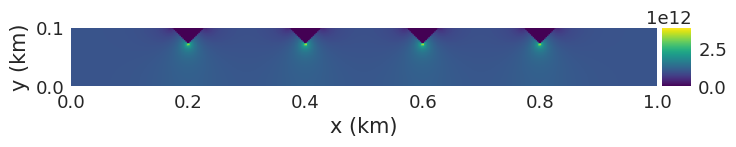

In [29]:
j_field.sel('z').norm.mpl()

In [30]:
j_field.to_file('current-profile.omf')